Для прогнозирования используются данные о покупках юзеров за период 2021 года. Всего доступно больше 2 млн. строк.

Флаг оттока проставляется, если после покупки юзера прошло больше 45 дней.

Поведение юзера описывается историей его покупок, суммой чека и размером скидки к чеку. В компании действует программа лояльности, участвуя в которой юзеры получают скидку на любую покупку и могут получать дополнительные скидки по разным промо-акциями.

Описание данных:
data.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'timestamp'` - дата и время совершения покупки, datetime
* `'gest_Sum'` - сумма покупки, float
* `'gest_Discount'` - сумма скидки, float

target.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'target'` - флаг оттока, int: 1 если юзер ушел в отток | 0 если НЕ отток

## Что здесь можно сделать? - Заметки 
**Нужно помнить, что по сути это тайм серия.**  -- **Внимательно!**  
Т.е. я предполагаю, что клиент покупает, покупает, покупает, потом фигак и перестал покупать. Один клиент - один вектор.
А тут куча вектором принадлежат одному клиенту. 

Т.е. я бы даже сказал, что в том виде в котором оно есть, модель особо-то ничего не найдет. Как она сможет по дате, сумме покупки и скидке предсказать уйдет человек или нет, не зная его истории?
---ОТВЕТ---
Да, это последовательность событий, но прям как таймсерию использовать не можем, потому что нерегулярные сигналы и из-за этого много сложностей.
Но! Можно использовать эти же строки, но к ним добавлять "память" о клиенте, т.е. его историю к конкретной сделке.

**Что может говорить, что клиент собрался уйти и не вернуться?**  
Т.е. гипотетически что может говорить о том, что клиент собирается уйти и не вернуться?
1. Увеличивается интервал между покупками от покупки к покупке. Типа 1 день, потом 2, потом 5 и т.д.
2. Как-то изменяется объем чека (уменьшается, увеличивается?) 
3. Как-то меняется ассортимент (типа вот он покупал одно и тоже, а тут вдруг перестал покупать одно и тоже (испортился товар на его вкус) и он либо сразу ушел, либо попробовал другое и остался, либо попробовал другое - ему не понравилось - ушел

**Как должен работать предикт? Какие данные должны поступать на вход?**  -- **Есть пол-ответа**  
~~Это видимо тоже относится к тому, что это своего рода таймсерия~~
Вся инфа находится в БД, которая обновляется ночью. И модель будет работать ночью и может использовать всю бд. Как именно пока я не понимаю.


**Если сейчас дать модели на вход просто дату, сумму чека и скидку...**  
То она будет пытаться предсказать отток исключительно по дате, сумме чеку и скидке - врядли у нее что-то получится взразумительное.


**Сумма в месяц стабильна для юзера, а отклонение может указывать на отток**  
По результатам уже проведенного анализа есть такой вывод:
сумма, которую готов тратить юзер в месяц,  достаточна стабильна и слабо меняется со временем. Потратив в этом месяце больше обычного, юзер скорее всего в следующем не будет покупать;

По каждому клиенту взять средний чек, каким-то образом определить порог отклонения от этого среднего чека и посмотреть насколько факт этого отклонения коррелирует с оттоком. Может это будет хорошая фича. Но проблема в том, что для предсказания не достаточно 

**Самый простой и очевидный способ подготовки данных**  
Это взять по каждому клиенту кол-во покупок, min,max,mean,median,stdev по gest_Sum, gest_Discount, и перерывом между покупками

**Вариант еще лучше!**  
Используем каждую строку как есть, не переводим ее в строку по уникальному клиенту, а точно также одна строка одна сделка.
К каждой такой строке мы накопительно добавляем кумулятивную инфу о клиенте, т.е.:
* Сколько дней на момент сделки прошло с момента первой сделки
* Какой на текущий момент средний чек
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем



# Вопросы:
**>>>Что значат 0 в gest_sum?<<<**

**Как работают скидки? Это накопительные баллы или просто скидки? Почему основные скидки не больше 100 руб, но бывают аж в 3000 руб.?**

## Описание общего подхода - not actual

Я вот вижу 3 общих подхода:
1. Рассматривать покупки клиентов как таймсерию, и исходя из прошлого поведения прогнозировать будущее. 
    * Мы таймсерии не проходили, плюс задача оттока традиционно не решается предсказанием таймсерии, поэтому от этого варианта скорее откажемся. Даже несмотря на то, что можно как-то обучить модель на скользящем окне (я точно не знаю как).
2. Преобразовать данные так, чтобы получилось по одной строке на каждого клиента, в которой будет какая-то агрегированная информация о покупках. В надежде, что модель найдет какие-то закономерности именно в общей репрезентации истории. 
3. Использовать данные в том виде, в котором они уже есть. Т.е. каждая строка это одна сделка. Но добавить к ним накопительную информацию об истории клиента. (Спасибо нашему ментору, который подсказал этот подход)
    * Т.е. к каждой сделке добавить инфу о кол-ве уже совершенных покупок, кол-во прошедших дней с предыдущей покупки, и другое.
    * Такой подход позволит модели сравнивать историю с текущей сделкой, что повышает ценность информации по сравнению с предыдущим подходом.
    
    
Наверное, главный мой вопрос для всех: какие есть еще подходы к решению задачи?

И перейдя на уровень ниже, предполагаю, что эффективность любого подхода зависит от того, какие фичи мы создадим/добавим.
А какие фичи нужно добавить зависит от того, как мы себе представляем механику и причины оттока клиентов.

Здесь можно как-то самостоятельно (коллективно) очертить эту механику, составить список фичей и уже отдать на откуп модели, чтобы она там сама определила какие фичи важны - какие нет.
Либо воспользоваться уже какой-то готовой теорией, например тот же RFM-анализ, о котором говорил Родион.
Не ясно какой подход эффективнее, т.е. стоит ли погружаться в теорию и если стоит то ради чего (только ради списка фичей, например)?
Это вот второй вопрос, который хотел бы обсудить.


И третий вопрос: про то, в каком виде будут приходить данные на предикт.
Это может повлиять на то, как нужно будет обучать модель.
Например, если предикт будет происходить исключительно по данным за последний месяц и только, то какой-то условный скрипт предобработки, который будет, например, считать средний чек может сильно ошибиться, т.к. ему будет не хватать данных. А модель мы обучали на целом годе и там статистики будут поточнее. И так возникает расхождение.
Вот такого рода ограничения. Я, к сожалению, другие примеры придумать не могу, но это все может сильно повлиять на архитектуру обработки данных и как следствие на то, что стоит ожидать от модели.

**not actual - end**

In [194]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score


In [2]:
# pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.3f}'.format

In [3]:
df = pd.read_csv('data/data.csv')
df_target = pd.read_csv('data/target.csv')

In [4]:
display(df.head())
df_target.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.0
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000000,55.0
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500000,25.5
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000000,0.0
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.899994,3.1


,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


## Предобработка датасетов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clnt_ID        object 
 1   timestamp      object 
 2   gest_Sum       float64
 3   gest_Discount  float64
dtypes: float64(2), object(2)
memory usage: 72.4+ MB


In [6]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


* timestamp - object, а не datetime

Изменим тип данных в timestamp на datetime

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

Добавим столбец с только датой.

In [8]:
df['date'] = df['timestamp'].dt.date

Проверим на дубликаты и пропуски.

In [9]:
df.isna().sum()

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
date             0
dtype: int64

Пропусков нет.

In [10]:
df.duplicated().sum()

129

Есть дубликаты, посмотрим на них.

In [11]:
df.loc[df.duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount,date
639,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200012,0.000000,2021-01-02
663,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200012,0.000000,2021-01-02
85786,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000000,0.000000,2021-01-14
85787,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000000,0.000000,2021-01-14
133279,A145C6F8-EDCB-47B1-BF5D-B328F6AF97CA,2021-01-20 16:00:00,0.000000,0.000000,2021-01-20
...,...,...,...,...,...
2165277,E99EFF35-01BE-49A9-8F61-641F752051E5,2021-11-08 15:00:00,0.000000,0.000000,2021-11-08
2174627,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.239990,37.759998,2021-11-10
2174629,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.239990,37.759998,2021-11-10
2198034,C9D86AF9-373C-4531-92A4-8FC752DD5D75,2021-11-14 12:00:00,0.000000,0.000000,2021-11-14


Удалим дубликаты.

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

Дубликаты удалили.

## Нужно создать фичи

Для анализа нужно создать фичи

**=====================================================**  
**=====================================================**  
**=====================================================**  
**СТАВИМ НА ПАУЗУ, СНАЧАЛА СДЕЛАТЬ EDA БЕЗ НОВЫХ ФИЧЕЙ, И БЕЙСЛАЙН, ЗАТЕМ УЖЕ НОВЫЕ ФИЧИ И НОВЫЕ МОДЕЛИ**  
**=====================================================**  
**=====================================================**  
**=====================================================**  

Общая стоимость заказа без скидки = `gest_Sum + gest_Discount`

In [14]:
# df['gest_total'] = df['gest_Sum'] + df['gest_Discount']

**Как создавать сложные фичи?**

* У нас есть целиковый датасет
* Нужно группировать его по клиентам
* Нужно к этим группам применять разные методы, чтобы уже эти фичи создать

`df.groupby('cnlt_ID').transform(func)`

**Какие создавать фичи?**
* Сколько дней на момент текущей сделки прошло с момента первой сделки
* Какой на текущий момент средний чек
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем

Сколько дней прошло с момента первой сделки

1. Берем min(date)
2. Вычитаем из текущей data min(date) (`df['date'] - df['first_buy_date']`)

In [15]:
# def first_buy_date(col):
# #     print(col.min())
#     return col - col.min()
# df['first_buy_date_delta'] = df.groupby('clnt_ID')['date'].transform(first_buy_date)
# df['first_buy_timestamp_delta'] = df.groupby('clnt_ID')['timestamp'].transform(first_buy_date)

In [16]:
# df['first_buy_date_delta'].dt.days.astype('int').hist(bins=100)

In [17]:
# df['first_buy_timestamp_delta'].dt.total_seconds().astype('int').hist(bins=100)

**Какой на текущий момент средний чек**

Берем кумулятивную сумму чека и делим на 

А лучше используем `series.expanding().mean()`
`df.groupby('clnt_ID').transform()`

При этом нам нужен среднее кол-во денег, которое отдал клиент, и средняя стоимость без учета скидки.

In [18]:
# def expand_mean(col):
#     return col.expanding().mean()
# df['clnt_gest_Sum_avg'] = df.groupby('clnt_ID')['gest_Sum'].transform(expand_mean)
# df['clnt_gest_total_avg'] = df.groupby('clnt_ID')['gest_total'].transform(expand_mean)

In [19]:
# df.head()

In [20]:
# df['clnt_gest_Sum_avg'].hist(bins=100)

**Какая разница между среднем чеком и чеком сделки**
Считаем для кол-ва денег и для стоимости без учета скидки (пока не ясно надо ли)

Берем текущий чек и из него вычитаем средний.
Тоже самое без учета скидки.

`df['gest_Sum'] - df['clnt_gest_Sum_avg']`
`df['gest_total'] - df['clnt_gest_total_avg']`

In [21]:
# df['gest_Sum_delta_from_avg'] = df['gest_Sum'] - df['clnt_gest_Sum_avg']
# df['gest_total_delta_from_avg'] = df['gest_total'] - df['clnt_gest_total_avg']

In [22]:
# df['gest_total_delta_from_avg'].hist(bins=100)

**Сколько сделок произошло на момент текущей сделки**
series.expanding().count()

In [23]:
# def expand_count(col):
#     return col.expanding().count()

# df['clnt_buys_count'] = df.groupby('clnt_ID')['timestamp'].transform(expand_count)

In [24]:
# df['clnt_buys_count'].describe()

In [25]:
# df['clnt_buys_count'].hist(bins=100)

**=====================================================**  
**=====================================================**  
**=====================================================**  
**СТАВИМ НА ПАУЗУ, СНАЧАЛА СДЕЛАТЬ EDA БЕЗ НОВЫХ ФИЧЕЙ, И БЕЙСЛАЙН, ЗАТЕМ УЖЕ НОВЫЕ ФИЧИ И НОВЫЕ МОДЕЛИ**  
**=====================================================**  
**=====================================================**  
**=====================================================**  

## EDA

Объединим датасеты для анализа.

In [26]:

df_eda = df.merge(df_target,on='clnt_ID')
display(df_eda.head(),df_eda.info(),df_eda.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2371506 entries, 0 to 2371505
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   clnt_ID        object        
 1   timestamp      datetime64[ns]
 2   gest_Sum       float64       
 3   gest_Discount  float64       
 4   date           object        
 5   target         int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 126.7+ MB


,clnt_ID,timestamp,gest_Sum,gest_Discount,date,target
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.000000,2021-01-02,0
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700012,131.300003,2021-01-07,0
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500000,272.500000,2021-01-09,0
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500000,112.500000,2021-01-11,0
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000000,60.000000,2021-01-12,0


None

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
date             0
target           0
dtype: int64

Посмотрим кол-во уникальный айдишников.

In [27]:
display(df['clnt_ID'].nunique())
df_target['clnt_ID'].nunique()

255109

255109

255109 клиентов. При этом в датасете с таргетом тоже 255109 записей. Значит все верно.

Посмотрим сколько из них с флагом.

In [28]:
df_target['target'].value_counts()

0    128857
1    126252
Name: target, dtype: int64

Примерно одинаково. Дисбаланса классов нет.

Проверим, что все правильно смержилось.

In [29]:
(df_eda.loc[df_eda['target']==0,'clnt_ID'].nunique(),df_eda.loc[df_eda['target']==1,'clnt_ID'].nunique())

(128857, 126252)

Да, кол-во уникальных айдишников в каждом классе осталось прежним.

Посмотрим сколько заказов (строк) приходится на каждый класс.

0    1699701
1     671805
Name: target, dtype: int64

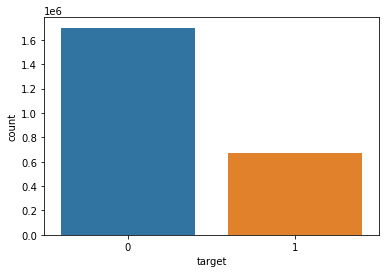

In [32]:
display(df_eda['target'].value_counts())
sns.countplot(x='target',data=df_eda)
plt.show()

Тут мы видим сразу, что те, кто уходят, значительно меньше раз совершали покупки.

### Задачи EDA

Сначала нужно исследовать данные том виде, в котором пришли.
Т.е. это даты, сумма чека с учетом скидки, размер скидки

Потом можно посравнивать агрегированную информацию каждого клиенту по таргету.

## Сделаем функцию дескрайб мою

In [123]:
def describe(col):
    """Функция выводит подробное числовое описание данных, 
    возвращает Figure,Axis объекты matplotlib.pyplot для гистограммы и ящика с усами.
    """

#     Подсчет количества значений
    count_ = col.count()
    
#     Меры центральной тенденции:
#     Среднее
    mean = col.mean()
#     Медиана
    median = col.median()
#     Мода
    mode = col.mode()

#     Меры разброса
#     Дисперсия
    var = col.var()
#     Стандартное отклонение
    stddev = col.std()
#     Межквартильный размах
    quartile_1 = col.quantile(0.25)
    quartile_3 = col.quantile(0.75)
    iqr = quartile_3 - quartile_1
#     Мин, макс, размах
    min_ = col.min()
    max_ = col.max()
    range_ = max_ - min_

#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
    
#    Количество выбросов
    outliers_mask = (col <= outlier_border_left) | (col >= outlier_border_right)
    outliers_count = col.loc[outliers_mask].count()
    outliers_proportion = outliers_count / count_
    
#     Создание и вывод таблицы с числовым описанием данных
    describe_ = {"count": count_,
                 "mean": mean,
                 "mode": mode,
                 "var": var,
                 "stddev": stddev,
                 "min": min_,
                 "25%": quartile_1,
                 "50%": median,
                 "75%": quartile_3,
                 "max": max_,
                 "total_range": range_,
                 "interquartile_range": iqr,
                 "outlier_border_left": outlier_border_left,
                 "outlier_border_right": outlier_border_right,
                 "outliers_count": outliers_count,
                 "outliers_proportion": outliers_proportion}
    describe_ = pd.DataFrame(describe_).transpose()
    describe_.columns = [col.name]
    return describe_

# describe(t_0)

,0
count,128857.000
mean,13.191
mode,1.000
var,959.692
stddev,30.979
min,1.000
25%,1.000
50%,2.000
75%,8.000
max,1314.000


### Функция построения двух гистограмм на одной фигуре

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='Сравнение статистики по категориям', ylabel='Частота'>)

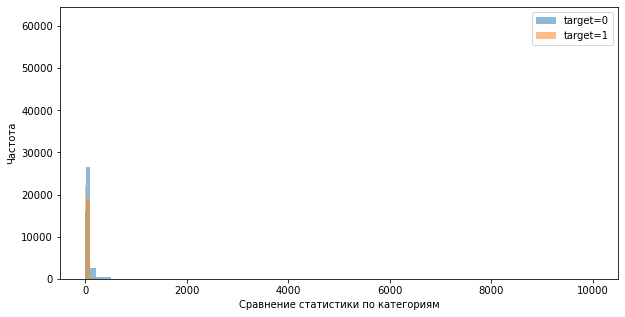

In [135]:
def multiv_target_hist_normalized(data_0,data_1,bins=1000,xlabel=None,figsize=(10,5)):
    """
    Построение двух полупрозрачных нормализованных гистограмм (с функцией плотности) на одной фигуре.
    Каждая гистограмма это подгруппа признака по таргету.
    
    """
    
#     canceled = data_train.loc[df['is_canceled'] == 1, column].sort_values()
#     not_canceled = data_train.loc[df['is_canceled'] == 0, column].sort_values()
    
    fig,ax = plt.subplots(figsize=figsize)
    
#     if bins == False:
#         bins = df[column].nunique()
        
    ax.hist(data_0,bins=bins,alpha=0.5,label=['target=0'])
    ax.hist(data_1,bins=bins,alpha=0.5,label=['target=1'])
    ax.set_ylabel('Частота')
    if xlabel == None:
        ax.set_xlabel("Сравнение статистики по категориям")
    else:
        ax.set_xlabel(xlabel)
    ax.legend()
    return fig,ax

multiv_target_hist_normalized(t_0,t_1,bins=[1,2,3,10,100,200,500,1000,10000])
# plt.xlim(0,200)

### Исследуем данные как есть

**timestamp и date**

In [69]:
df['timestamp'].describe(datetime_is_numeric=True)

count                          2371506
mean        2021-06-09 07:33:53.499232
min         2021-01-02 09:09:17.060000
25%      2021-03-15 21:59:01.061499904
50%         2021-05-27 16:38:57.212000
75%      2021-09-01 18:12:35.844999936
max         2021-12-15 22:45:31.087000
Name: timestamp, dtype: object

In [76]:
df.loc[df['timestamp'].duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount,date
257,A3D0C62A-C36E-4282-8CAE-F7182A344D94,2021-01-02 11:00:00,1630.000000,0.000000,2021-01-02
258,C109CE2C-595E-4626-8556-E1AA0C62C6C4,2021-01-02 11:00:00,857.520020,0.000000,2021-01-02
259,B7AD30FD-46CE-4FDE-9A4D-7B92D7C768B7,2021-01-02 11:00:00,529.000000,0.000000,2021-01-02
260,650265AE-9718-442C-9658-FF08120951AE,2021-01-02 11:00:00,1189.000000,0.000000,2021-01-02
261,B6C81087-749F-43E0-9C52-D6575F9042D6,2021-01-02 11:00:00,1658.880005,0.000000,2021-01-02
...,...,...,...,...,...
2371314,1DFCF34F-F1ED-4B15-BCD2-11FC4BBC710E,2021-12-15 20:30:00,241.500000,47.500000,2021-12-15
2371364,C37F5569-08CE-4599-AD90-BF593883FC98,2021-12-15 20:40:00,559.000000,0.000000,2021-12-15
2371365,A9FBBF96-6B09-48E0-8C55-E3E754414599,2021-12-15 20:40:00,1123.199951,46.799999,2021-12-15
2371527,5C5D0F65-AC7E-44BA-807D-9A97F01B8CC6,2021-12-15 21:25:00,215.250000,38.750000,2021-12-15


<AxesSubplot:>

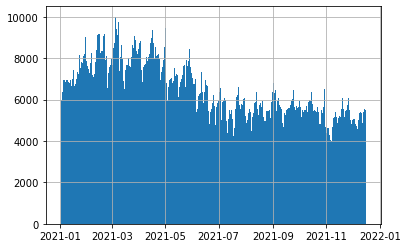

In [67]:
df['timestamp'].hist(bins=365)

In [78]:
df['date'].describe()

count        2371506
unique           348
top       2021-04-30
freq           10823
Name: date, dtype: object

<AxesSubplot:>

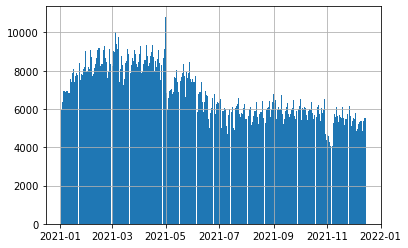

In [77]:
df['date'].hist(bins=365)

* Да ничего неожиданного. Что я тут вообще ожидал найти?

**gest_Sum**

In [86]:
# fig,ax = simple_uni_EDA(df,"gest_Sum")
# ax.set_xlabel("Сумма чека за вычетом скидки")
# ax.set_title("Гистограмма и ящик с усами суммы чека за вычетом скидки")
# ax.set_xlim(0,5000)
# plt.show()
# **ПРОБЛЕМА С ФУНКЦИЕЙ**
# Мне тут не нравится, что нельзя изменять кол-во бинов.
# **ПРОБЛЕМА С ФУНКЦИЕЙ**

df['gest_Sum'].describe()

count    2.371506e+06
mean     4.526220e+02
std      4.147803e+02
min      0.000000e+00
25%      1.953000e+02
50%      3.408000e+02
75%      5.782000e+02
max      2.350000e+04
Name: gest_Sum, dtype: float64

Есть 0. Что это значит?

Посмотрим на эти строки, где `'gest_Sum' == 0`

In [81]:
df.loc[df['gest_Sum']==0].describe()

,gest_Sum,gest_Discount
count,3702.0,3702.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


* Возможно это отмена заказа?

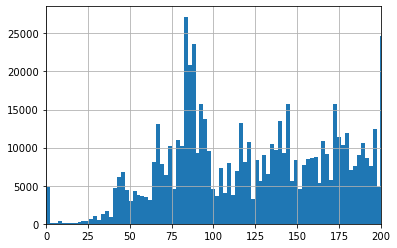

In [92]:
df['gest_Sum'].hist(bins=10000)
plt.xlim(0,200)
plt.show()

Есть какой-то странный пик в районе от 75 до 100 руб. Это покупка кофе?

In [95]:
df.loc[(df['gest_Sum'] > 75)&(df['gest_Sum'] < 100)].describe()

,gest_Sum,gest_Discount
count,146631.000000,146631.000000
mean,87.308680,17.606549
std,5.731060,82.426449
min,75.099998,0.000000
25%,83.199997,0.000000
50%,86.400002,2.800000
75%,92.000000,5.600000
max,99.900002,1545.640015


Сложно сказать что-то конкретное.

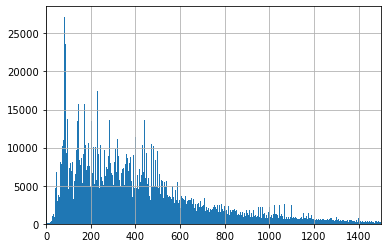

In [96]:
df['gest_Sum'].hist(bins=10000)
plt.xlim(0,1500)
plt.show()

Что тут еще добавить? Я не знаю.

**gest_Discount**

In [136]:
df['gest_Discount'].describe()

count   2371506.000
mean         41.469
std          84.531
min           0.000
25%           3.100
50%          14.000
75%          44.700
max        3957.500
Name: gest_Discount, dtype: float64

(0.0, 100.0)

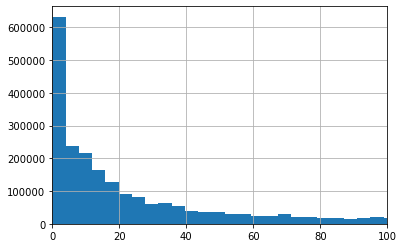

In [102]:
df['gest_Discount'].hist(bins=1000)
plt.xlim(0,100)

Ну как бы и чо? Я не понимаю что я тут должен найти, кроме того что это не нормальное распределение.

### Исследуем агрегированные данные

У нас есть кол-во сделок; мин, макс, среднее, медиана, мода, стандартное отклонение `'gest_Sum'`, `'gest_Discount'`. И нам надо их сравнить по таргету, чтобы выяснить как эти статистики отличаются по категориям.

Напишем функцию, которая будет подготавливать такие датасеты со статистиками по категориям.

In [108]:
def cat_split(value,aggfunc):
    pivot_table = df_eda.pivot_table(index='clnt_ID', values=value, aggfunc=aggfunc,columns='target')
    target_0 = pivot_table[0].dropna()
    target_1 = pivot_table[1].dropna()
    return target_0, target_1

# cat_split('date','count')

In [125]:
t_0, t_1 = cat_split('date','count')
describe(t_0).join(describe(t_1))

,0,1
count,128857.000,126252.000
mean,13.191,5.321
mode,1.000,1.000
var,959.692,72.673
stddev,30.979,8.525
min,1.000,1.000
25%,1.000,1.000
50%,2.000,2.000
75%,8.000,6.000
max,1314.000,400.000


In [124]:
describe(t_0).join(describe(t_1))

,0,1
count,128857.000,126252.000
mean,13.191,5.321
mode,1.000,1.000
var,959.692,72.673
stddev,30.979,8.525
min,1.000,1.000
25%,1.000,1.000
50%,2.000,2.000
75%,8.000,6.000
max,1314.000,400.000


(0.0, 100.0)

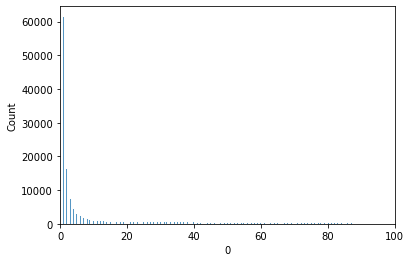

In [115]:
sns.histplot(t_0)
plt.xlim(0,100)

In [33]:
# В итоге мы пока откажемся от подхода с таймсериес, и возьмем просто описание истории покупок клиентов.
# Т.е. берем фичи сумма чека, скидка, дней с последней покупки для каждого клиента и сравнимаем эти статистики по группам 0 и 1 (таргету)
df_eda.pivot_table(index='clnt_ID', values=['gest_Sum','gest_Discount'],aggfunc=['count','min','max','median','mean','std'],columns='target')

count                       \
                                     gest_Discount       gest_Sum         
target                                           0     1        0     1   
clnt_ID                                                                   
000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A           NaN   3.0      NaN   3.0   
00007EB0-6331-438E-A917-E9840C260876           1.0   NaN      1.0   NaN   
0000993D-A30E-4233-AB3F-D368D9A0D2C4           NaN   1.0      NaN   1.0   
0000A724-7BC5-408F-9F16-6CC3AB16322F          64.0   NaN     64.0   NaN   
0000B90C-56DE-43C2-A213-624AFBE36DB2           1.0   NaN      1.0   NaN   
...                                            ...   ...      ...   ...   
FFFF1629-85B6-9DD3-994C-5E21A88A5BFF           1.0   NaN      1.0   NaN   
FFFF364C-972B-4F77-9A75-AF62F01E6B7B           NaN   1.0      NaN   1.0   
FFFF3BC7-D0FB-4630-8D09-1D4088C5A297           NaN   2.0      NaN   2.0   
FFFF788D-F1CF-4A74-B825-FAF05BC062C1           NaN   1.0      NaN   1.0   
FFFFBA18-758F-4CAF-8437-1E0A73670F7D           NaN  26.0      NaN  26.0   

                                               min                         \
                                     gest_Discount       gest_Sum           
target                                           0     1        0       1   
clnt_ID                                                                     
000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A           NaN  10.0      NaN   490.0   
00007EB0-6331-438E-A917-E9840C260876           6.0   NaN    214.0     NaN   
0000993D-A30E-4233-AB3F-D368D9A0D2C4           NaN   0.0      NaN   470.0   
0000A724-7BC5-408F-9F16-6CC3AB16322F           0.0   NaN      0.0     NaN   
0000B90C-56DE-43C2-A213-624AFBE36DB2           0.0   NaN    549.0     NaN   
...                                            ...   ...      ...     ...   
FFFF1629-85B6-9DD3-994C-5E21A88A5BFF           0.0   NaN   1269.0     NaN   
FFFF364C-972B-4F77-9A75-AF62F01E6B7B           NaN  27.0      NaN   383.0   
FFFF3BC7-D0FB-4630-8D09-1D4088C5A297           NaN   0.0      NaN  1366.5   
FFFF788D-F1CF-4A74-B825-FAF05BC062C1           NaN  37.0      NaN    37.0   
FFFFBA18-758F-4CAF-8437-1E0A73670F7D           NaN   0.0      NaN    84.0   

                                               max              ...  \
                                     gest_Discount              ...   
target                                           0           1  ...   
clnt_ID                                                         ...   
000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A           NaN   44.799999  ...   
00007EB0-6331-438E-A917-E9840C260876      6.000000         NaN  ...   
0000993D-A30E-4233-AB3F-D368D9A0D2C4           NaN    0.000000  ...   
0000A724-7BC5-408F-9F16-6CC3AB16322F    280.799988         NaN  ...   
0000B90C-56DE-43C2-A213-624AFBE36DB2      0.000000         NaN  ...   
...                                            ...         ...  ...   
FFFF1629-85B6-9DD3-994C-5E21A88A5BFF      0.000000         NaN  ...   
FFFF364C-972B-4F77-9A75-AF62F01E6B7B           NaN   27.000000  ...   
FFFF3BC7-D0FB-4630-8D09-1D4088C5A297           NaN    0.000000  ...   
FFFF788D-F1CF-4A74-B825-FAF05BC062C1           NaN   37.000000  ...   
FFFFBA18-758F-4CAF-8437-1E0A73670F7D           NaN  113.099998  ...   

                                           median                       mean  \
                                         gest_Sum              gest_Discount   
target                                          0            1             0   
clnt_ID                                                                        
000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A          NaN   519.400024           NaN   
00007EB0-6331-438E-A917-E9840C260876   214.000000          NaN        6.0000   
0000993D-A30E-4233-AB3F-D368D9A0D2C4          NaN   470.000000           NaN   
0000A724-7BC5-408F-9F16-6CC3AB16322F   260.550003          NaN       31.1625   
0000B90C-56DE-43C2-A213-624AFBE36DB2   549.000000        

Напишем функцию для упрощения анализа статистик по категориям.

In [63]:
def simple_uni_EDA(df,column):
    """Функция выводит подробное числовое описание данных, 
    возвращает Figure,Axis объекты matplotlib.pyplot для гистограммы и ящика с усами.
    """

#     Подсчет количества значений
    count_ = df[column].count()
    
#     Меры центральной тенденции:
#     Среднее
    mean = df[column].mean()
#     Медиана
    median = df[column].median()
#     Мода
    mode = df[column].mode()

#     Меры разброса
#     Дисперсия
    var = df[column].var()
#     Стандартное отклонение
    stddev = df[column].std()
#     Межквартильный размах
    quartile_1 = df[column].quantile(0.25)
    quartile_3 = df[column].quantile(0.75)
    iqr = quartile_3 - quartile_1
#     Мин, макс, размах
    min_ = df[column].min()
    max_ = df[column].max()
    range_ = max_ - min_

#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
    
#    Количество выбросов
    outliers_mask = (df[column] <= outlier_border_left) | (df[column] >= outlier_border_right)
    outliers_count = df.loc[outliers_mask,column].count()
    outliers_proportion = outliers_count / count_
    
#     Создание и вывод таблицы с числовым описанием данных
    describe_ = {"count": count_,
                 "mean": mean,
                 "mode": mode,
                 "var": var,
                 "stddev": stddev,
                 "min": min_,
                 "25%": quartile_1,
                 "50%": median,
                 "75%": quartile_3,
                 "max": max_,
                 "total_range": range_,
                 "interquartile_range": iqr,
                 "outlier_border_left": outlier_border_left,
                 "outlier_border_right": outlier_border_right,
                 "outliers_count": outliers_count,
                 "outliers_proportion": outliers_proportion}
    describe_ = pd.DataFrame(describe_).transpose()
    describe_.columns = [column]
    with pd.option_context("display.float_format", '{:.3f}'.format):
                           display(describe_)
    

#     Построение гистограммы, ящика с усами
    fig,ax = plt.subplots(figsize=(16,8))
    ax.hist(df[column],bins=30)
    ax.set_ylabel("Частота")
    ax2=ax.twinx()
    ax2.boxplot(df[column],vert=False)
    
    return fig,ax

def qqplot(df,column):
    """Функция возвращает Figure,Axis объекты matplotlib.pyplot для normal qqplot."""
    fig,ax = plt.subplots(figsize=(8,8))
    sm.qqplot(df[column], line='45',fit=True,ax=ax)
    return fig,ax

,gest_Sum
count,2371506.000
mean,452.622
mode,201.600
var,172042.693
stddev,414.780
min,0.000
25%,195.300
50%,340.800
75%,578.200
max,23500.000


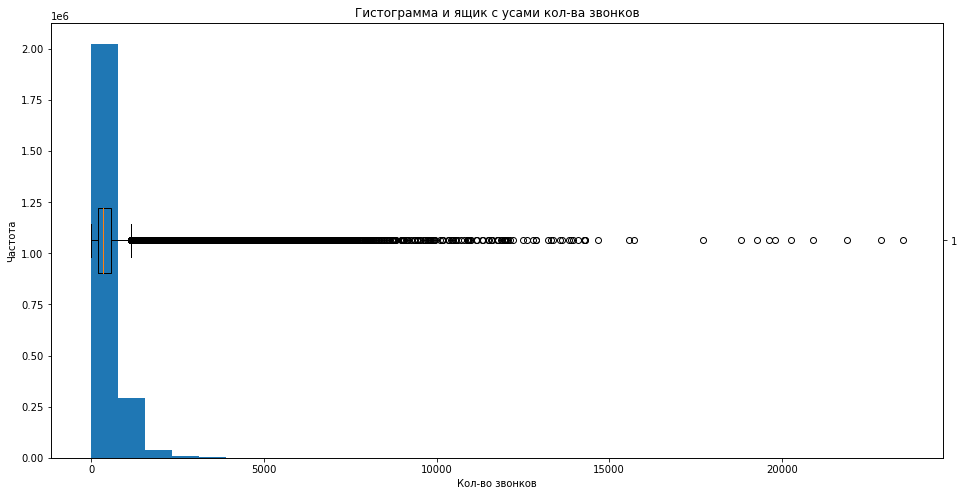

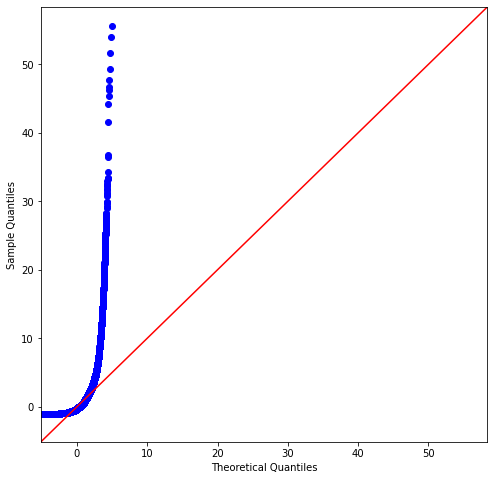

In [64]:
fig,ax = simple_uni_EDA(df,"gest_Sum")
ax.set_xlabel("Кол-во звонков")
ax.set_title("Гистограмма и ящик с усами кол-ва звонков")
plt.show()
# fig,ax = qqplot(df,"gest_Sum")
# plt.show()

1.0      61461
2.0      16207
3.0       7392
4.0       4511
5.0       2992
         ...  
293.0        1
434.0        1
431.0        1
304.0        1
358.0        1
Name: 0, Length: 390, dtype: int64

1.0      43704
2.0      22235
3.0      13127
4.0       8472
5.0       5982
         ...  
354.0        1
144.0        1
115.0        1
143.0        1
331.0        1
Name: 1, Length: 145, dtype: int64

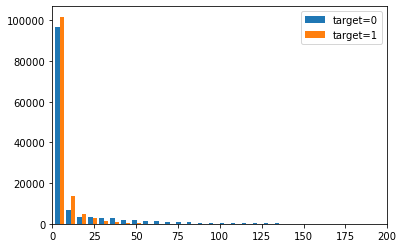

In [56]:
def eda(value,aggfunc,bins):
    eda = df_eda.pivot_table(index='clnt_ID',values=value,aggfunc=aggfunc,columns='target')
    t_0 = eda.iloc[:,0].dropna()
    t_1 = eda.iloc[:,1].dropna()
    display(t_0.value_counts())
    display(t_1.value_counts())
    return plt.hist([t_0,t_1],bins=bins,label=['target=0','target=1'])
    
    
eda('gest_Sum','count',200)
plt.xlim(0,200)
plt.legend()
plt.show()

# BASELINE

Для бейслайна используем данные в таком виде:
Группируем по клиенту,
берем общее число покупок
мин,макс,медиана,среднее,стд отклонение по gest_Sum, gest_Discount, кол-во дней между покупками.

Пробуем логистическую регрессию - для нее стандартизируем
Пробуем дерево решение - можно ничего не делать с данными
Пробуем случайный лет - тоже можно ничего не делать

Оцениваем ф1 по кроссвалидации на 5 фолдах (?)

In [151]:
df_baseline = df.copy()

Создадим фичу - кол-во дней между покупками.
Потом ее переместим в нужное место.

In [152]:
def expand_count(col):
    return col.expanding().count()

df_baseline['clnt_buys_count'] = df_baseline.groupby('clnt_ID')['timestamp'].transform(expand_count)

In [153]:
df_baseline = df_baseline.drop(columns=['timestamp'])

In [154]:
df_baseline.head()

,clnt_ID,gest_Sum,gest_Discount,date,clnt_buys_count
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,900.000,300.000,2021-01-02,1.000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,165.000,55.000,2021-01-02,1.000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,800.500,25.500,2021-01-02,1.000
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,580.000,0.000,2021-01-02,1.000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,148.900,3.100,2021-01-02,1.000


Как использовать дату

In [ ]:
df_eda.pivot_table(index='clnt_ID', values=['gest_Sum','gest_Discount'],aggfunc=['count','min','max','median','mean','std'],columns='target')

In [155]:
df_baseline.columns

Index(['clnt_ID', 'gest_Sum', 'gest_Discount', 'date', 'clnt_buys_count'], dtype='object')

In [169]:
aggfunc_dict = {'date': ['count'],
                'gest_Sum': ['min','max','median','mean','std'], 
                'gest_Discount': ['min','max','median','mean','std'], 
                'clnt_buys_count': ['max','median','mean','std']} # здесь min не нужен, т.к. везде будут 1

In [170]:
pivot_baseline = df_baseline.pivot_table(index='clnt_ID', values=['date','gest_Sum','gest_Discount','clnt_buys_count'],aggfunc=aggfunc_dict, fill_value=0)

In [176]:
pivot_baseline.columns = ['_'.join(column) for column in pivot_baseline.columns]

MultiIndex([('clnt_buys_count',    'max'),
            ('clnt_buys_count',   'mean'),
            ('clnt_buys_count', 'median'),
            ('clnt_buys_count',    'std'),
            (           'date',  'count'),
            (  'gest_Discount',    'max'),
            (  'gest_Discount',   'mean'),
            (  'gest_Discount', 'median'),
            (  'gest_Discount',    'min'),
            (  'gest_Discount',    'std'),
            (       'gest_Sum',    'max'),
            (       'gest_Sum',   'mean'),
            (       'gest_Sum', 'median'),
            (       'gest_Sum',    'min'),
            (       'gest_Sum',    'std')],
           )

In [178]:
pivot_baseline.describe()

,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,date_count,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std
count,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000
mean,9.296,5.148,5.148,2.645,9.296,96.011,46.174,40.298,30.937,21.568,885.385,609.003,586.838,449.685,161.768
std,23.156,11.578,11.578,6.752,23.156,185.499,138.910,139.234,137.689,46.447,724.995,538.335,543.737,553.309,244.786
min,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,408.900,295.000,268.000,118.000,0.000
50%,2.000,1.500,1.500,0.707,2.000,26.800,11.213,0.000,0.000,0.000,728.000,470.171,438.000,260.000,77.737
75%,6.000,3.500,3.500,1.871,6.000,103.400,39.200,26.400,5.200,29.506,1189.000,760.000,737.500,582.000,254.650
max,1314.000,657.500,657.500,379.463,1314.000,3957.500,2780.500,2780.500,2780.500,1463.401,23500.000,23500.000,23500.000,23500.000,15247.626


In [164]:
pivot_baseline.isna().sum()

clnt_buys_count  max       0
                 mean      0
                 median    0
                 min       0
                 std       0
date             count     0
gest_Discount    max       0
                 mean      0
                 median    0
                 min       0
                 std       0
gest_Sum         max       0
                 mean      0
                 median    0
                 min       0
                 std       0
dtype: int64

In [181]:
# pivot_baseline_full = pivot_baseline.join(df_target)
pivot_baseline_full = pivot_baseline.merge(df_target,on='clnt_ID')

In [183]:
pivot_baseline_full = pivot_baseline_full.drop(columns=['clnt_ID'])
pivot_baseline_full.head()

,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,date_count,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std,target
0,3,2.000,2.000,1.000,3,44.800,21.800,10.600,10.000,19.921,566.200,525.200,519.400,490.000,38.430,1
1,1,1.000,1.000,0.000,1,6.000,6.000,6.000,6.000,0.000,214.000,214.000,214.000,214.000,0.000,0
2,1,1.000,1.000,0.000,1,0.000,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000,0.000,1
3,64,32.500,32.500,18.619,64,280.800,31.162,8.550,0.000,62.320,562.600,274.228,260.550,0.000,118.275,0
4,1,1.000,1.000,0.000,1,0.000,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000,0.000,0


In [184]:
X = pivot_baseline_full.drop(columns=['target'])
y = pivot_baseline_full['target']

In [185]:
X.head()

,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,date_count,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std
0,3,2.000,2.000,1.000,3,44.800,21.800,10.600,10.000,19.921,566.200,525.200,519.400,490.000,38.430
1,1,1.000,1.000,0.000,1,6.000,6.000,6.000,6.000,0.000,214.000,214.000,214.000,214.000,0.000
2,1,1.000,1.000,0.000,1,0.000,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000,0.000
3,64,32.500,32.500,18.619,64,280.800,31.162,8.550,0.000,62.320,562.600,274.228,260.550,0.000,118.275
4,1,1.000,1.000,0.000,1,0.000,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000,0.000


In [186]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [203]:
log_reg = LogisticRegression()
log_reg_cv = cross_validate(log_reg, X, y, cv=5, scoring='f1')

c:\Users\SnakeRZR\Desktop\sample_project_1\enc\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\SnakeRZR\Desktop\sample_project_1\enc\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [206]:
tree = DecisionTreeClassifier()
tree_cv = cross_validate(tree,X,y,cv=5,scoring='f1')

In [207]:
forest = RandomForestClassifier()
forest_cv = cross_validate(forest,X,y,cv=5,scoring='f1')

In [209]:
tree_cv['test_score'].mean()

0.5824813921947174

In [212]:
log_reg_f1 = log_reg_cv['test_score'].mean()
tree_f1 = tree_cv['test_score'].mean()
forest_f1 = forest_cv['test_score'].mean()
print(f'log_reg_f1 = {log_reg_f1} /n tree_f1 = {tree_f1} /n forest_f1={forest_f1}')

log_reg_f1 = 0.49489292810094654 /n tree_f1 = 0.5824813921947174 /n forest_f1=0.6423907431852178
